In [3]:
%matplotlib inline
import pandas
import seaborn
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

## Nonlinear problems

Up to now, we have been solving linear problems.  The preferred way to leverage fast linear solves for (potentially ill-conditioned) nonlinear problems is via defect correction, usually Newton methods.

### The Newton-Raphson method for scalar problems

Much of numerical analysis reduces to [Taylor series](https://en.wikipedia.org/wiki/Taylor_series), the approximation
$$ f(x) = f(x_0) + f'(x_0) (x-x_0) + \underbrace{f''(x_0) (x - x_0)^2 / 2 + \dotsb}_{O((x-x_0)^2)} $$
centered on some reference point $x_0$.

In numerical computation, it is exceedingly rare to look beyond the first-order approximation
$$ \tilde f_{x_0}(x) = f(x_0) + f'(x_0)(x - x_0) . $$
Since $\tilde f_{x_0}(x)$ is a linear function, we can explicitly compute the unique solution of $\tilde f_{x_0}(x) = 0$ as
$$ x = x_0 - f(x_0) / f'(x_0) . $$
This is Newton's Method (aka Newton-Raphson or Newton-Raphson-Simpson) for finding the roots of differentiable functions.

test_func 0 -2 -0.44851788021624484
test_func 1 -2.579508809224632 -0.07804240445653787
test_func 2 -2.7502278755485423 -0.01169737888867406
test_func 3 -2.787065713793899 -0.0005874789197288788
test_func 4 -2.7891231086081634 -1.8550336560174685e-06
test_func 5 -2.7891296463678903 -1.874356225783913e-11
test_func 6 -2.7891296464339503 0.0


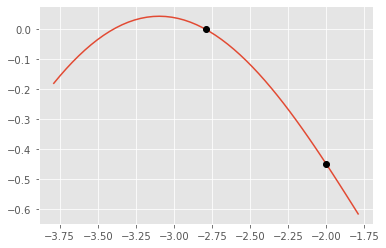

In [20]:
def newton(func, x, verbose=False):
    """Solve f(x) = 0 using initial guess x.
    
    The provided function func must return a pair of values,
    f(x) and its derivative f'(x).  For example, to solve
    the equation x^2 - 3 starting from initial guess x=1,
    one would write
    
    def func(x):
        return x**2 - 3, 2*x
        
    newton(func, 1)
    """
    for i in range(100):
        fx, dfx = func(x)
        if verbose:
            print(func.__name__, i, x, fx)
        if np.abs(fx) < 1e-12:
            return x, fx, i
        try:
            x -= fx / dfx
        except ZeroDivisionError:
            return x, np.NaN, i
        
def test_func(x):
    f = np.exp(x) - np.cos(x) - 1
    dfdx = np.exp(x) + np.sin(x)
    return f, dfdx

x0 = -2
root, _, _ = newton(test_func, x0, verbose=1)
x = np.linspace(min(x0,root)-1, max(x0,root+1))
plt.plot(x, test_func(x)[0])
plt.plot([x0,root], test_func([x0,root])[0], 'ok');

* We say this method converges **quadratically** since the number of correct digits doubles each iteration.
* The initial guess matters; a bad initial guess can take us to the wrong solution or cause divergence.

### Systems of equations

We've been solving linear systems, such as those resulting from discretizing linear PDE.  To address nonlinear problems (be they from PDE or otherwise), we'll express our problem as
$$ F(u) = 0 $$
where $u$ is a vector of state variables and $F(u)$ is a vector of residuals of the same length.
Note that linear problems can be written in this form, $F(u) = A u - b$.
We will primarily be interested in defect correction methods of the form
\begin{gather} A \delta u = - F(u) \\
u \gets u + \gamma \delta u
\end{gather}
where $A$ is a matrix and $\gamma$ is a scalar parameter that may need to be found using an iteration.

* If $A = I$, this is a Richardson iteration, which is related to gradient descent.  Such methods are usually quite slow unless $F(u)$ is especially "nice".
* If $A = \partial F/\partial u$, this is a Newton method and $\gamma=1$ can often be used.


## Newton-Raphson methods for systems

The **Jacobian** of $F$ is
$$ J(u) = \frac{\partial F}{\partial u}(u) =
\begin{bmatrix} \frac{\partial F_0}{\partial u_0} & \frac{\partial F_0}{\partial u_1} & \dotsb \\
 \frac{\partial F_1}{\partial u_0} & \frac{\partial F_1}{\partial u_1} &  \\
 \vdots & & \ddots
 \end{bmatrix}(u) . $$
The method can be derived by taking the Taylor expansion of $F(u)$ at $u$,
$$ F(u + \delta u) = F(u) + \frac{\partial F}{\partial u}(u) (\delta u) + \frac{\partial^2 F}{\partial u^2}(u) (\delta u \otimes \delta u) / 2 + \dotsb $$
Note that each higher term is a higher rank tensor, thus computationally unweildy.  If we truncate the series with the linear term and set equal to zero, we have a linear equation for $\delta u$
$$ \frac{\partial F}{\partial u}(u) \delta u = - F(u) $$
which will hopefully make $F(u + \partial u) \approx 0$.  This is Newton's method.

* Each iteration requires evaluating $F(u)$ -- almost any method will have this property.
* Each iteration requires evaluating the Jacobian matrix $J(u)$ -- this either requires custom code, algorithmic differentiation, or a finite difference approximation (we'll revisit this later).
* Each iteration requires solving a linear system with the matrix $J(u)$.  This may be expensive.

In [2]:
def fsolve_newton(F, J, u0, rtol=1e-10, maxit=50, verbose=False):
    u = u0.copy()
    Fu = F(u)
    norm0 = np.linalg.norm(Fu)
    enorm_last = np.linalg.norm(u - np.array([1,1]))
    for i in range(maxit):
        du = -np.linalg.solve(J(u), Fu)
        u += du
        Fu = F(u)
        norm = np.linalg.norm(Fu)
        if verbose:
            enorm = np.linalg.norm(u - np.array([1,1]))
            print('Newton {:d} anorm {:6.2e} rnorm {:6.2e} eratio {:6.2f}'.
                  format(i+1, norm, norm/norm0, enorm/enorm_last**2))
            enorm_last = enorm
        if norm < rtol * norm0:
            break
    return u, i

def rostest(a,b):
    def F(u):
        x = u[0]; y = u[1]
        return np.array([-2*(a-x) + 4*b*x**3 - 4*b*x*y,
                         2*b*(y-x**2)])
    def J(u):
        x = u[0]; y = u[1]
        return np.array([[2 + 12*b*x**2 - 4*b*y, -4*b*x],
                         [-4*b*x, 2*b]])
    return F, J

F, J = rostest(1,3)
fsolve_newton(F, J, np.array([0, 1.]), verbose=True)

Newton 1 anorm 2.51e+00 rnorm 3.96e-01 eratio   1.56
Newton 2 anorm 9.91e+00 rnorm 1.57e+00 eratio   0.56
Newton 3 anorm 3.83e-01 rnorm 6.05e-02 eratio   0.22
Newton 4 anorm 5.11e-01 rnorm 8.08e-02 eratio   0.25
Newton 5 anorm 5.24e-04 rnorm 8.28e-05 eratio   0.36
Newton 6 anorm 9.76e-07 rnorm 1.54e-07 eratio   0.21
Newton 7 anorm 3.61e-15 rnorm 5.72e-16 eratio   0.31


(array([1., 1.]), 6)

* Can the iteration break down?  How?
* How does the method depend on the initial guess?
* It turns out that Newton's method has _locally quadratic_ convergence to simple roots, $$\lim_{i \to \infty} |e_{i+1}|/|e_i^2| < \infty .$$
* "The number of correct digits doubles each iteration."
* Now that we know how to make a good guess accurate, the effort lies in getting a good guess.

## Matrix-free Jacobian via finite differencing

It can be error-prone and complicated to implement the Jacobian function `J(u)`.  In such cases, we can use the approximation

$$ J(u) v \approx \frac{F(u+\epsilon v) - F(u)}{\epsilon} $$

where $\epsilon$ is some "small" number.  Now can't access individual entries of $J$, but we can apply its action to an arbitrary vector $u$.

We know that this approximation is first order accurate in $\epsilon$, 
$$ \left\lVert J(u) v - \frac{F(u+\epsilon v) - F(u)}{\epsilon} \right\rVert \in O(\epsilon) . $$
But if $\epsilon$ is too small, we will lose accuracy due to rounding error.  If $F$ has been scaled such that its norm is of order 1, then $\epsilon = \sqrt{\epsilon_{\text{machine}}}$ is a good default choice.

In [3]:
import scipy.sparse.linalg as splinalg

def fsolve_newtonkrylov(F, u0, epsilon=1e-8, rtol=1e-10, maxit=50, verbose=False):
    u = u0.copy()
    Fu = F(u)
    norm0 = np.linalg.norm(Fu)
    for i in range(maxit):
        def Ju_fd(v):
            return (F(u + epsilon*v) - Fu) / epsilon
        Ju = splinalg.LinearOperator((len(Fu),len(u)), matvec=Ju_fd)
        du, info = splinalg.gmres(Ju, Fu, atol=1.e-6)
        if info != 0:
            print(np.linalg.norm(Ju @ du - Fu), norm)
            raise RuntimeError('GMRES failed to converge: {:d}'.format(info))
        u -= du
        Fu = F(u)
        norm = np.linalg.norm(Fu)
        if verbose:
            print('Newton {:d} anorm {:6.2e} rnorm {:6.2e}'
                  .format(i, norm, norm/norm0))
        if norm < rtol * norm0:
            break
    return u, i

fsolve_newtonkrylov(F, np.array([0.,1]), rtol=1e-6, verbose=True)

Newton 0 anorm 2.51e+00 rnorm 3.96e-01
Newton 1 anorm 9.91e+00 rnorm 1.57e+00
Newton 2 anorm 3.83e-01 rnorm 6.05e-02
Newton 3 anorm 5.11e-01 rnorm 8.08e-02
Newton 4 anorm 5.24e-04 rnorm 8.28e-05
Newton 5 anorm 9.76e-07 rnorm 1.54e-07


(array([1.        , 0.99999992]), 5)

### Jacobian-Free Newton Krylov (JFNK) and Preconditioning

While matrix-free finite differencing can save us the need to assemble the Jacobian (and write code to do that), there is no free lunch: Krylov convergence will be slow unless we have a good preconditioner.  But sometimes there are short-cuts: we can assemble a cheaper approximation for preconditioning, or develop multigrid methods that don't involve any assembled matrices.

#### Further reading

* Knoll and Keyes (2004) [**Jacobian-free Newton–Krylov methods: a survey of approaches and applications**](https://www.cs.odu.edu/~keyes/papers/jfnk.pdf)

## Case study: Newton-Krylov Multigrid methods for hydrostatic ice flow

This is a strongly nonlinear problem for which convergence of a high-resolution model stagnates if the initial guess isn't good.  It is, however, amenable to a method called grid sequencing where we solve coarse problems to generate initial guesses on the fine grid. At each grid level, we solve nonlinear problems using Newton-Krylov methods preconditioned by multigrid.

![](tme-ice-nk.png)

![](tme-ice-its.png)

![](tme-ice-breakdown.png)

## Further reading

* Brown, Smith, and Ahmadia (2013) [**Textbook multigrid efficiency for hydrostatic ice flow**](https://doi.org/10.1137/110834512)
  * Configuring an efficient nonlinear solver (see `snes/examples/tutorials/ex48.c` in PETSc repository)

### Costs

* Residual evaluation $F(u)$
* Jacobian assembly $J(u) = F'(u)$
* Preconditioner setup $M^{-1}$
* Jacobian application $J(u) v$
* Preconditioner application $M^{-1} v$
* Krylov vector work: inner products and vector axpy

#### Shifting costs
* Approximate Jacobian
* Less expensive preconditioner `-pc_type jacobi`
* Lag the preconditioner `-snes_lag_preconditioner`
* Lag the Jacobian `-snes_lag_jacobian`
* Matrix-free finite differencing to skip assembly of Jacobian `-snes_mf` or `-snes_mf_operator`

A good PETSc example to test with: `src/snes/examples/tutorials/ex15.c`

## Transient problems

When solving time-dependent problems such as

$$ \frac{\partial_u(x,t)}{\partial t} = f\big(u(x,t), t\big) $$

we have a choice between explicit methods and implicit methods.  Explicit methods only require that we evaluate $f(u,t)$ on each time step while implicit methods require solves (linear or nonlinear).  However, for problems with multiple time scales, explicit method may be unstable unless using time steps that are much shorter than would be needed for accuracy, thus implicit methods are often preferred.  This adds another layer of complementary costs.